# Import all the required libraries

---


In [1]:
import os
import glob

import torch
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from rich.console import Console
from rich.table import Table
from IPython.display import clear_output


from neural_networks import StockPricePredictor

# Dataset preparation

---

## Load the dataset


In [2]:
data_dir = os.path.join('..', 'data', 'original')
dataset_path = os.path.join(data_dir, 'AAPL.csv')
# all_stocks = glob.glob(os.path.join(data_dir, '*.csv'))
# if len(all_stocks) == 0:
#     raise FileNotFoundError('No stock data found in the data directory - download some OHLC data first')

# dataset_path = all_stocks[0]
dataset = pd.read_csv(dataset_path)
print(dataset.head())
print(dataset.shape)

                        Date      Open      High       Low     Close   
0  1980-12-12 00:00:00-05:00  0.100764  0.101203  0.100764  0.100764  \
1  1980-12-15 00:00:00-05:00  0.095946  0.095946  0.095508  0.095508   
2  1980-12-16 00:00:00-05:00  0.088936  0.088936  0.088498  0.088498   
3  1980-12-17 00:00:00-05:00  0.090688  0.091126  0.090688  0.090688   
4  1980-12-18 00:00:00-05:00  0.093317  0.093755  0.093317  0.093317   

      Volume  Dividends  Stock Splits  
0  469033600        0.0           0.0  
1  175884800        0.0           0.0  
2  105728000        0.0           0.0  
3   86441600        0.0           0.0  
4   73449600        0.0           0.0  
(11018, 8)


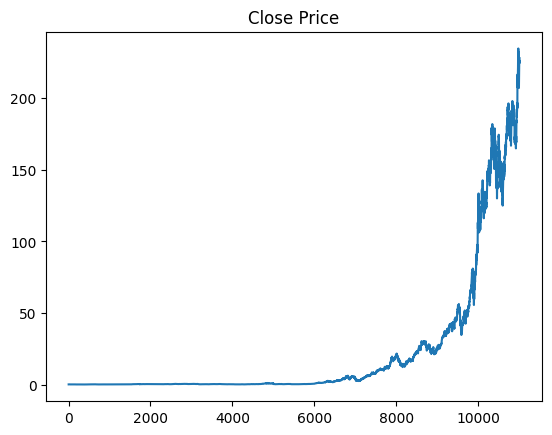

In [3]:
plt.title('Close Price')
plt.plot(dataset['Close'])

## Prepare the dataset for training


In [4]:
dataset = dataset.drop(['Date', 'Dividends', 'Stock Splits'], axis=1)
print(dataset.head())

       Open      High       Low     Close     Volume
0  0.100764  0.101203  0.100764  0.100764  469033600
1  0.095946  0.095946  0.095508  0.095508  175884800
2  0.088936  0.088936  0.088498  0.088498  105728000
3  0.090688  0.091126  0.090688  0.090688   86441600
4  0.093317  0.093755  0.093317  0.093317   73449600


In [5]:
# scale the data
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume']
scaler = MinMaxScaler()
dataset[columns_to_scale] = scaler.fit_transform(dataset[columns_to_scale])
print(dataset.head())

       Open      High       Low     Close    Volume
0  0.000261  0.000262  0.000267  0.000265  0.063198
1  0.000241  0.000240  0.000244  0.000243  0.023699
2  0.000211  0.000211  0.000214  0.000213  0.014246
3  0.000219  0.000220  0.000224  0.000222  0.011647
4  0.000230  0.000231  0.000235  0.000233  0.009897


### Compute technical indicators


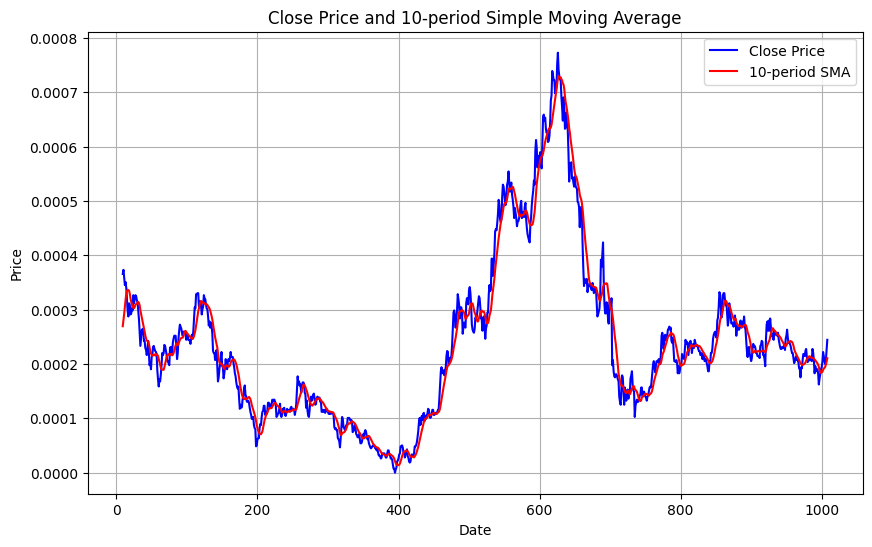

In [6]:
SMA_LENGTH = 10
dataset['SMA_'+str(SMA_LENGTH)] = ta.sma(dataset['Close'], length=SMA_LENGTH)
df = dataset.dropna()[:1000]
plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.plot(df['SMA_'+str(SMA_LENGTH)], label=f'{str(SMA_LENGTH)}-period SMA', color='red')
plt.title(f'Close Price and {SMA_LENGTH}-period Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Moving Average Convergence Divergence (MACD)
macd_df = ta.macd(dataset['Close'])    # macd, histogram, signal column
dataset['MACD'] = macd_df['MACD_12_26_9']

# Bollinger Bands
bb_df = ta.bbands(dataset['Close'], length=20).drop(columns=['BBB_20_2.0', 'BBP_20_2.0'])
dataset = pd.concat([dataset, bb_df], axis=1)

# Relative Volume (RVOL)
dataset['RVOL'] = dataset['Volume'] / dataset['Volume'].rolling(window=20).mean()

# Williams %R
dataset['Williams_%R'] = ta.willr(dataset['High'], dataset['Low'], dataset['Close'], length=14)

# Chaikin Money Flow (CMF)
dataset['CMF'] = ta.cmf(dataset['High'], dataset['Low'], dataset['Close'], dataset['Volume'], length=20)

# Detrended Price Oscilator (DPO)
dataset['DPO'] = ta.dpo(dataset['Close'], length=20)

# Stochastic Oscillator (STOCH)
stoch_df = ta.stoch(dataset['High'], dataset['Low'], dataset['Close'], length=14)
dataset['%K'] = stoch_df['STOCHk_14_3_3']
dataset['%D'] = stoch_df['STOCHd_14_3_3']

dataset.dropna(inplace=True)
print(dataset.head(15))

        Open      High       Low     Close    Volume    SMA_10      MACD   
25  0.000309  0.000308  0.000314  0.000312  0.004053  0.000303  0.000006  \
26  0.000317  0.000320  0.000323  0.000321  0.002143  0.000305  0.000007   
27  0.000322  0.000325  0.000329  0.000327  0.004790  0.000309  0.000008   
28  0.000322  0.000323  0.000327  0.000325  0.001512  0.000310  0.000008   
29  0.000315  0.000314  0.000320  0.000317  0.003320  0.000311  0.000008   
30  0.000313  0.000312  0.000316  0.000313  0.003193  0.000313  0.000007   
31  0.000296  0.000296  0.000301  0.000299  0.003794  0.000314  0.000006   
32  0.000280  0.000279  0.000284  0.000282  0.005916  0.000312  0.000003   
33  0.000258  0.000257  0.000259  0.000258  0.006224  0.000308 -0.000001   
34  0.000232  0.000231  0.000235  0.000233  0.003202  0.000299 -0.000007   
35  0.000245  0.000246  0.000250  0.000248  0.002581  0.000292 -0.000009   
36  0.000259  0.000260  0.000265  0.000263  0.003755  0.000286 -0.000010   
37  0.000259

### Compute target variable


In [8]:
price_movement = (dataset['Close'].shift(-1) > dataset['Close']).astype(int)  # 1 for up, 0 for down
# remove the last row, because we don't have the next day's price movement for it
price_movement = price_movement[:-1]
dataset = dataset[:-1]

all_features = dataset.values
main_ohlc_features = dataset[['Open', 'High', 'Low', 'Close', 'Volume']].values

print(all_features.shape, main_ohlc_features.shape)
print(price_movement.shape)

# df = pd.DataFrame(ohlc_data, columns=features)
# df['Price_movement'] = price_movement.values
# print(df.head(10))

(10981, 16) (10981, 5)
(10981,)


# Training

---

## Hyperparameters


In [9]:
# Dataset
SEQUENCE_LENGTH =  40
BATCH_SIZE = 256

# Training 
criterion = torch.nn.BCELoss()
EPOCHS = 30

## Creating sequences for recurrent neural network


In [10]:
def create_sequences(data, target, SEQUENCE_LENGTH):
    X, y = [], []
    for i in range(len(data) - SEQUENCE_LENGTH):
        X.append(data[i:i+SEQUENCE_LENGTH])
        y.append(target[i+SEQUENCE_LENGTH-1])
    
    X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
    y_tensor = torch.tensor(np.array(y), dtype=torch.float32)
    return X_tensor, y_tensor

X_tensor_ohlc, y_tensor_ohlc = create_sequences(main_ohlc_features, price_movement, SEQUENCE_LENGTH)
X_tensor_all, y_tensor_all = create_sequences(all_features, price_movement, SEQUENCE_LENGTH)
print(X_tensor_ohlc.shape, y_tensor_ohlc.shape)
print(X_tensor_all.shape, y_tensor_all.shape)

torch.Size([10941, 40, 5]) torch.Size([10941])
torch.Size([10941, 40, 16]) torch.Size([10941])


## Sliting the dataset into training and testing set


In [11]:
def get_dataset_loaders(X_tensor, y_tensor, BATCH_SIZE):
    X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, shuffle=False)
    X_train = X_train[:-SEQUENCE_LENGTH]
    y_train = y_train[:-SEQUENCE_LENGTH] 

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, test_loader

train_loader_ohlc, test_loader_ohlc = get_dataset_loaders(X_tensor_ohlc, y_tensor_ohlc, BATCH_SIZE)
train_loader_all, test_loader_all = get_dataset_loaders(X_tensor_all, y_tensor_all, BATCH_SIZE)

## Training


In [12]:
console = Console()

def create_table():
    table = Table(title='Training Progress')
    table.add_column('Epoch', style='cyan', justify='center')
    table.add_column('Train Loss', style='magenta', justify='center')
    table.add_column('Train Accuracy', style='magenta', justify='center')
    table.add_column('Val Loss', style='green', justify='center')
    table.add_column('Val Accuracy', style='green', justify='center')
    table.add_column('Val Precision', style='green', justify='center')
    table.add_column('Val Recall', style='green', justify='center')
    table.add_column('Val F1 Score', style='green', justify='center')
    table.add_column('Val MCC', style='green', justify='center')
    return table

**Early Stopping** based on testing accuracy


In [13]:
MODEL_PATH = os.path.join('.', 'lstm.pth')
EARLY_STOPPING_PATIENCE = 10

def train(input_size, train_loader, test_loader):
    table = create_table()
    # Model - batch_first=True means: [batch_size, seq_len, input_size]
    model = StockPricePredictor(input_size=input_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = np.inf
    best_model = None

    df = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Train Accuracy', 'Val Loss', 'Val Accuracy', 'Val Precision', 'Val Recall', 'Val F1 Score', 'Val MCC'])
    train_accuracies = []
    val_accuracies = []

    best_val_accuracy = 0
    early_stopping_counter = 0
    epoch = 0
    while True:
    # for epoch in range(EPOCHS):
        epoch += 1
        early_stopping_counter += 1

        train_correct = 0
        model.train()

        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()

            outputs = model(inputs)
            # print(outputs, labels)
            labels = labels.unsqueeze(1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            predictions = (outputs > 0.5).float()
            train_correct += (predictions == labels).sum().item()

        train_accuracy = train_correct / len(train_loader.dataset)


        model.eval()    # disable operations like dropout, batchnorm, etc.
        
        total = 0
        val_loss = 0.0

        tp, tn, fp, fn = 0, 0, 0, 0
        all_predictions = []
        all_outputs = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels.unsqueeze(1)).item()

                outputs = outputs.squeeze()
                predictions = (outputs > 0.5).float()
                # print(outputs, labels)
                all_outputs.extend(outputs.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                tp += (predictions * labels).sum().item()
                tn += ((1 - predictions) * (1 - labels)).sum().item()
                fp += (predictions * (1 - labels)).sum().item()
                fn += ((1 - predictions) * labels).sum().item()

                total += labels.size(0)

        # print(tp, tn, fp, fn)
        assert(total == (tp + tn + fp + fn))
        val_accuracy = (tp + tn)/total
        val_precision = tp/(tp + fp + 1e-6)
        val_recall = tp/(tp + fn + 1e-6)
        val_f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall + 1e-6)
        val_mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), MODEL_PATH)
            early_stopping_counter = 0
        elif early_stopping_counter > EARLY_STOPPING_PATIENCE:
            print(f'Early stopping at epoch {epoch}')
            break

        table.add_row(str(epoch), f'{running_loss/len(train_loader):.4f}', f'{train_accuracy*100:.2f}%', f'{val_loss/len(test_loader):.4f}', f'{val_accuracy*100:.2f}%', f'{val_precision:.4f}', f'{val_recall:.4f}', f'{val_f1_score:.4f}', f'{val_mcc:.4f}')
        console.clear()
        clear_output(wait=True)
        console.print(table)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

    console.clear()
    return train_accuracies, val_accuracies, best_val_accuracy

Training on dataset with only OHLC data - no technical indicators

In [14]:
ohlc_train_accuracies, ohlc_test_accuracies, ohlc_best_val_accuracy = train(X_tensor_ohlc.shape[2], train_loader_ohlc, test_loader_ohlc)
print(f'Best validation accuracy: {ohlc_best_val_accuracy*100:.4f}%')

                                                 Training Progress                                                 
┏━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┓
┃       ┃            ┃    Train     ┃          ┃              ┃     Val      ┃            ┃   Val F1    ┃         ┃
┃ Epoch ┃ Train Loss ┃   Accuracy   ┃ Val Loss ┃ Val Accuracy ┃  Precision   ┃ Val Recall ┃    Score    ┃ Val MCC ┃
┡━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━┩
│   1   │   0.6932   │    51.11%    │  0.6916  │    53.04%    │    0.5304    │   1.0000   │   0.6931    │   nan   │
│   2   │   0.6941   │    49.12%    │  0.6938  │    46.96%    │    0.0000    │   0.0000   │   0.0000    │   nan   │
│   3   │   0.6933   │    51.06%    │  0.6939  │    46.96%    │    0.0000    │   0.0000   │   0.0000    │   nan   │
│   4   │   0.6932   │    51.03%    │  0.6939  │    46.96%    │    0.0000    │   0.0000   │   0.0000    │   nan   │
│   5   │   0.6932   │    51.03%    │  0.6940  │    46.96%    │    0.0000    │   0.0000   │   0.0000    │   nan   │
│   6   │   0.6931   │    51.03%    │  0.6940  │    46.96%    │    0.0000    │   0.0000   │   0.0000    │   nan   │
│   7   │   0.6930   │    51.03%    │  0.6940  │    46.96%    │    0.0000    │   0.0000   │   0.0000    │   nan   │
│   8   │   0.6930   │    51.03%    │  0.6941  │    46.96%    │    0.0000    │   0.0000   │   0.0000    │   nan   │
│   9   │   0.6931   │    51.03%    │  0.6939  │    46.96%    │    0.0000    │   0.0000   │   0.0000    │   nan   │
│  10   │   0.6930   │    51.03%    │  0.6939  │    46.96%    │    0.0000    │   0.0000   │   0.0000    │   nan   │
│  11   │   0.6930   │    51.03%    │  0.6939  │    46.96%    │    0.0000    │   0.0000   │   0.0000    │   nan   │
└───────┴────────────┴──────────────┴──────────┴──────────────┴──────────────┴────────────┴─────────────┴─────────┘

Early stopping at epoch 12


Best validation accuracy: 53.0379%


Training on datset with technical indicators

In [15]:
all_train_accuracies, all_test_accuracies, all_best_val_accuracy = train(X_tensor_all.shape[2], train_loader_all, test_loader_all)
print(f'Best validation accuracy: {all_best_val_accuracy*100:.4f}%')

                                                 Training Progress                                                 
┏━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┓
┃       ┃            ┃    Train     ┃          ┃              ┃     Val      ┃            ┃   Val F1    ┃         ┃
┃ Epoch ┃ Train Loss ┃   Accuracy   ┃ Val Loss ┃ Val Accuracy ┃  Precision   ┃ Val Recall ┃    Score    ┃ Val MCC ┃
┡━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━┩
│   1   │   0.6868   │    54.76%    │  0.6813  │    57.15%    │    0.5865    │   0.6512   │   0.6171    │ 0.1346  │
│   2   │   0.6845   │    55.88%    │  0.6819  │    56.01%    │    0.5664    │   0.7278   │   0.6370    │ 0.1055  │
│   3   │   0.6829   │    56.28%    │  0.6799  │    57.24%    │    0.5856    │   0.6632   │   0.6220    │ 0.1356  │
│   4   │   0.6817   │    56.46%    │  0.6813  │    56.56%    │    0.5748    │   0.6951   │   0.6292    │ 0.1190  │
│   5   │   0.6800   │    57.04%    │  0.6808  │    57.24%    │    0.5796    │   0.7054   │   0.6364    │ 0.1331  │
│   6   │   0.6800   │    57.86%    │  0.6747  │    59.39%    │    0.6131    │   0.6348   │   0.6238    │ 0.1830  │
│   7   │   0.6788   │    56.98%    │  0.6780  │    58.75%    │    0.5968    │   0.6848   │   0.6378    │ 0.1660  │
│   8   │   0.6698   │    59.29%    │  0.6735  │    59.66%    │    0.6172    │   0.6305   │   0.6238    │ 0.1892  │
│   9   │   0.6649   │    60.16%    │  0.6676  │    60.30%    │    0.6170    │   0.6632   │   0.6393    │ 0.1998  │
│  10   │   0.6608   │    60.41%    │  0.6735  │    59.98%    │    0.6066    │   0.6985   │   0.6493    │ 0.1913  │
│  11   │   0.6566   │    61.34%    │  0.6580  │    60.85%    │    0.6389    │   0.6021   │   0.6200    │ 0.2174  │
│  12   │   0.6562   │    61.07%    │  0.6552  │    61.95%    │    0.6633    │   0.5736   │   0.6152    │ 0.2452  │
│  13   │   0.6507   │    63.45%    │  0.6443  │    63.50%    │    0.6602    │   0.6425   │   0.6512    │ 0.2687  │
│  14   │   0.6473   │    64.00%    │  0.6420  │    64.96%    │    0.6916    │   0.6124   │   0.6496    │ 0.3040  │
│  15   │   0.6358   │    65.30%    │  0.6372  │    65.01%    │    0.6549    │   0.7192   │   0.6855    │ 0.2947  │
│  16   │   0.6325   │    64.22%    │  0.6310  │    65.78%    │    0.6597    │   0.7330   │   0.6944    │ 0.3104  │
│  17   │   0.6434   │    63.83%    │  0.6469  │    61.90%    │    0.6253    │   0.7028   │   0.6618    │ 0.2311  │
│  18   │   0.6547   │    61.15%    │  0.6404  │    62.72%    │    0.6284    │   0.7270   │   0.6741    │ 0.2476  │
│  19   │   0.6153   │    65.97%    │  0.6346  │    65.83%    │    0.6664    │   0.7123   │   0.6886    │ 0.3118  │
│  20   │   0.5803   │    70.19%    │  0.5701  │    72.00%    │    0.7131    │   0.7898   │   0.7495    │ 0.4368  │
│  21   │   0.5335   │    73.97%    │  0.5476  │    72.45%    │    0.7564    │   0.7089   │   0.7319    │ 0.4503  │
│  22   │   0.4992   │    76.09%    │  0.5021  │    77.11%    │    0.7444    │   0.8656   │   0.8005    │ 0.5441  │
│  23   │   0.3973   │    83.30%    │  0.5534  │    76.24%    │    0.6970    │   0.9767   │   0.8135    │ 0.5680  │
│  24   │   0.3827   │    83.03%    │  0.4578  │    80.49%    │    0.8023    │   0.8389   │   0.8202    │ 0.6080  │
│  25   │   0.3206   │    86.42%    │  0.7106  │    69.85%    │    0.6959    │   0.7666   │   0.7295    │ 0.3931  │
│  26   │   0.3836   │    83.46%    │  0.5453  │    78.07%    │    0.7406    │   0.9027   │   0.8137    │ 0.5696  │
│  27   │   0.2930   │    88.10%    │  0.3346  │    86.66%    │    0.8673    │   0.8837   │   0.8754    │ 0.7320  │
│  28   │   0.2570   │    89.62%    │  0.3345  │    86.93%    │    0.8875    │   0.8630   │   0.8751    │ 0.7385  │
│  29   │   0.2395   │    90.29%    │  0.3339  │    86.75%    │    0.8837    │   0.8639   │   0.8737    │ 0.7347  │
│  30   │   0.2474   │    90.08%    │  0.3569  │    86.0

Early stopping at epoch 46


Best validation accuracy: 87.8483%


# Visualization

---


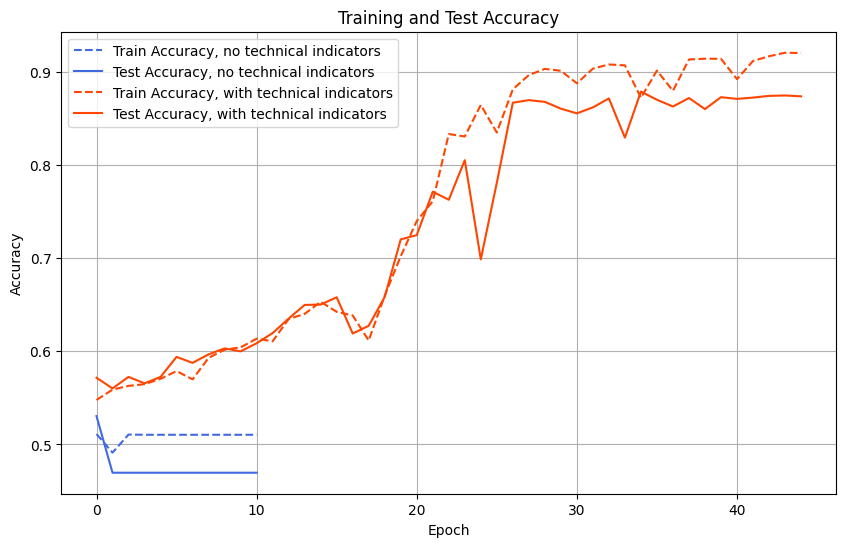

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(ohlc_train_accuracies, label='Train Accuracy, no technical indicators', color='royalblue', linestyle='dashed')
plt.plot(ohlc_test_accuracies, label='Test Accuracy, no technical indicators', color='royalblue')
plt.plot(all_train_accuracies, label='Train Accuracy, with technical indicators', color='orangered', linestyle='dashed')
plt.plot(all_test_accuracies, label='Test Accuracy, with technical indicators', color='orangered')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()